# Basic Analysis

## Tweet and user volume

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import itertools
import collections
from datetime import datetime
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag']]

In [3]:
df['wanted_tag'].value_counts()

True     64336
False    52592
Name: wanted_tag, dtype: int64

In [4]:
df.columns

Index(['author.description', 'author.id', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count', 'author.username', 'author_id',
       'created_at', 'id', 'lang', 'public_metrics.retweet_count', 'text',
       'hashtags', 'reference_type', 'wanted_tag'],
      dtype='object')

In [5]:
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_date = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [6]:
#number of total tweets
print(df.shape[0])
#number of total unique users
print(len(pd.unique(df['author.id'])))

116928
19010


In [7]:
#List the distribution of languages in the tweets (important for preprocessing (stopwords etc.))
print(df_date['lang'].value_counts())

de     99219
en     13648
und     3147
fr       302
ja        61
es        52
nl        51
it        32
is        29
da        21
pt        20
no        18
lt        17
tr        16
ca        14
pl        14
sv        14
ro         6
hi         4
et         4
cs         3
in         3
ar         3
tl         3
fi         3
lv         3
fa         2
cy         2
ht         2
vi         1
zh         1
ru         1
eu         1
Name: lang, dtype: int64


As tweets with undefined language mostly consist of only hashtags, URls or emojis, they will be discarded. Otherwise only german and english tweets are kept for the analysis

In [8]:
df_date = df_date.loc[(df_date['lang'] == "de") | (df_date['lang'] == "en")]

In [9]:
pd.set_option('display.max_rows', 100)
#number of remaining tweets
print(df_date.shape[0])
#number of remaining unique users
print(len(pd.unique(df_date['author.id'])))
#overview over "missing values"
print(df_date.count())

112867
18534
author.description                       107368
author.id                                112867
author.name                              112867
author.public_metrics.followers_count    112867
author.public_metrics.following_count    112867
author.username                          112867
author_id                                112867
created_at                               112867
id                                       112867
lang                                     112867
public_metrics.retweet_count             112867
text                                     112867
hashtags                                  70374
reference_type                           112867
wanted_tag                               112867
new_date                                 112867
dtype: int64


<AxesSubplot:xlabel='week'>

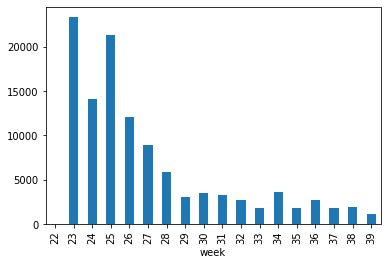

In [10]:
week_groups = df_date.groupby([pd.to_datetime(df_date['new_date']).dt.isocalendar().week]).size()
week_groups.plot(kind='bar', legend = False)

In [11]:
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]

<AxesSubplot:xlabel='new_date'>

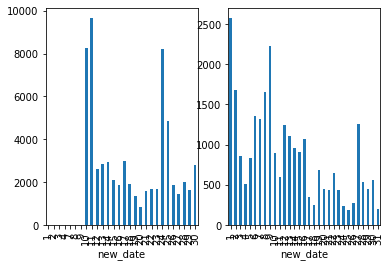

In [12]:
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
june_groups.plot(kind='bar', legend = False)
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
july_groups.plot(kind='bar', legend = False)

<AxesSubplot:xlabel='new_date'>

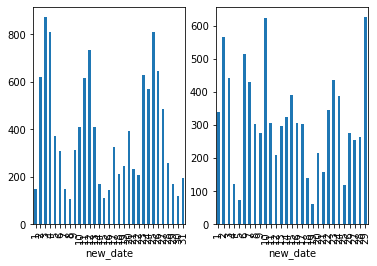

In [13]:
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
plt.subplot(1, 2, 1)
august_groups.plot(kind='bar', legend = False)
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()
plt.subplot(1, 2, 2)
september_groups.plot(kind='bar', legend = False)

## Missing Hashtag-Problem

In [14]:
#number of tweets actually containing the hashtag
df_hash = df_date[df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_hash.shape[0])

60832


In [15]:
#number of tweets not containing the hashtag directly
df_no_hash = df_date[-df_date['text'].str.contains("#ichbinhanna", case = False)]
print(df_no_hash.shape[0])

52035


In [16]:
#number of tweets without the hashtag that are retweets (text from original tweet cut off)
print(df_no_hash[df_no_hash['reference_type'] == 'retweeted'].shape[0])
#number of tweets with the hashtag that are retweets
print(df_hash[df_hash['reference_type'] == 'retweeted'].shape[0])

47468
40896


In [17]:
test =df_no_hash['text'].loc[df_no_hash['reference_type'] != 'retweeted']
test

2         Hanna is probably packing her/his/they suitcas...
80        Gefühlt die ganze Sozialwissenschaftsnation be...
84        Sobering data from @AAUP: In the fall of 2019,...
90        I finally heard from JW. *Some* of the misogyn...
108       QS World University Rankings 2022: Top 10: 5 🇺...
                                ...                        
116896    "Kaputte Böden, alte zerkratzte Tische und ein...
116905    "Museumsverband Sachsen-Anhalt" https://t.co/V...
116907    A few years back at a conference, a prof told ...
116912    Überwiegend befristete Verträge sorgen für Pre...
116926    Verhandelter Tarif.\nRechtsschutz im Arbeitsle...
Name: text, Length: 4567, dtype: object

In [18]:
print(df_hash['reference_type'].value_counts())
print(df_no_hash['reference_type'].value_counts())

retweeted       40896
no_reference     8159
quoted           6205
replied_to       5572
Name: reference_type, dtype: int64
retweeted       47468
replied_to       2760
no_reference     1253
quoted            554
Name: reference_type, dtype: int64


As a majority of those tweets are retweets that are mostly cut off due to the character constraint, a first approach is to exclude retweets directly for the sentiment analysis, as the original tweet (as long as it falls into our time frame) is most likely in the collection as well. If certain users or networks have to be observed, the whole data set might be of more interest.

In [19]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df_no_hash.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Get top hashtags appearing in tweets along with #IchBinHanna in september

In [20]:
#make the hashtags a list of strings, then adapt the monthly data frames, also remove tweets not containing the hashtag,
#but keep retweets for this part of the analysis
df_date = df_hash
df_date['hashtags'] = df_hash['hashtags'].str.replace('[', '').str.replace(']','')
df_date['hashtags separated'] = df_date['hashtags'].str.split(',')
df_september = df_date.loc[(df_date['new_date'] > '2021-09-01 00:00:00') & (df_date['new_date'] <= '2021-09-30 23:59:59')]
df_june = df_date.loc[(df_date['new_date'] > '2021-06-01 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59')]
df_july = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-31 23:59:59')]
df_august = df_date.loc[(df_date['new_date'] > '2021-08-01 00:00:00') & (df_date['new_date'] <= '2021-08-31 23:59:59')]
june_groups = df_june.groupby([pd.to_datetime(df_june['new_date']).dt.day]).size()
july_groups = df_july.groupby([pd.to_datetime(df_july['new_date']).dt.day]).size()
august_groups = df_august.groupby([pd.to_datetime(df_august['new_date']).dt.day]).size()
september_groups = df_september.groupby([pd.to_datetime(df_september['new_date']).dt.day]).size()

In [21]:
print(len(df_september))
print(len(df_june))
print(len(df_july))
print(len(df_august))

4455
37258
13642
5477


In [22]:
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags = df_september['hashtags separated'].explode().to_frame().dropna()
flat_hashtags = flat_hashtags[-flat_hashtags['hashtags separated'].str.contains("ichbinhanna", case = False)]

In [23]:
#count occurences 
hashtag_count = flat_hashtags.value_counts()
hashtag_count = hashtag_count[hashtag_count > 10].reset_index()

In [24]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='top_hashtags.csv')  
hashtag_count.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Identify Events by observing spikes in tweet volume

In [25]:
print("Highest activity in June:\n{}".format(june_groups.sort_values(ascending = False).head(10)))
print("Highest activity in July:\n{}".format(july_groups.sort_values(ascending = False).head(10)))
print("Highest activity in August:\n{}".format(august_groups.sort_values(ascending = False).head(10)))
print("Highest activity in September:\n{}".format(september_groups.sort_values(ascending = False).head(10)))

Highest activity in June:
new_date
11    5989
10    4566
24    4168
25    3019
14    1852
17    1689
30    1514
12    1502
13    1420
26    1271
dtype: int64
Highest activity in July:
new_date
1     1465
9     1258
8     1048
2     1045
6      693
7      682
12     679
16     512
13     486
10     477
dtype: int64
Highest activity in August:
new_date
3     491
25    441
2     390
12    369
4     347
10    280
23    270
26    268
20    204
11    204
dtype: int64
Highest activity in September:
new_date
10    397
29    362
23    285
2     246
6     245
7     231
24    201
1     198
11    190
22    175
dtype: int64


### First approach: search for most frequent words in tweets with the hashtag for the days with the highest activity

Retweets are kept here, as they give an indication about the engagement of a topic and reflect that in a higher word count for frequently discussed themes.

In [26]:
#First step: process the raw text data
#remove linebreaks separately
df_date['processed text'] = df_date['text'].replace(r'\\n',  ' ', regex=True)
#function to remove URLs, punctuation, @ etc. (source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_date['processed text'] = df_date['processed text'].apply(rem_url)

In [27]:
#lowercases and tokenize text
df_date['processed text'] = df_date['processed text'].str.lower().str.split()

In [28]:
#remove german and english stopwords (separately for the given language of a tweet)
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_date['processed w/o stopwords'] = df_date[['processed text','lang']].apply(lambda x: ' '.join([word for word in x['processed text'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed text'] if word not in (german_stop)]).split(),axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_date['processed w/o stopwords'] = df_date['processed w/o stopwords'].apply(lambda x: [word for word in x if len(word) > 2])

In [30]:
#most frequent words overall
all_words = list(itertools.chain(*df_date['processed w/o stopwords']))
total_word_count = collections.Counter(all_words)
total_word_count.most_common(25)

[('ichbinhanna', 59236),
 ('innen', 6229),
 ('amreibahr', 5585),
 ('bund', 5301),
 ('bmbf', 5075),
 ('amp', 5056),
 ('wissenschaft', 4578),
 ('wisszeitvg', 4384),
 ('hanna', 4134),
 ('wissenschaftler', 3673),
 ('drkeichhorn', 3410),
 ('viele', 3240),
 ('mehr', 2953),
 ('german', 2848),
 ('mal', 2501),
 ('heute', 2452),
 ('system', 2256),
 ('ichbinhannah', 2251),
 ('geht', 2099),
 ('schon', 1968),
 ('anjakarliczek', 1871),
 ('gibt', 1840),
 ('gerade', 1794),
 ('hannaimbundestag', 1754),
 ('gew', 1715)]

In [31]:
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_date['processed w/o stopwords'] = df_date[['processed w/o stopwords','lang']].apply(lambda x: ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['processed w/o stopwords'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)

In [32]:
#get most frequent terms for days with highest tweet volume per month
current_day = df_date.loc[(df_date['new_date'] > '2021-06-10 00:00:00') & (df_date['new_date'] <= '2021-06-10 23:59:59')]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-11 00:00:00') & (df_date['new_date'] <= '2021-06-11 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("11.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-24 00:00:00') & (df_date['new_date'] <= '2021-06-24 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("24.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-25 00:00:00') & (df_date['new_date'] <= '2021-06-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-17 00:00:00') & (df_date['new_date'] <= '2021-06-17 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("17.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-06-30 00:00:00') & (df_date['new_date'] <= '2021-06-30 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("30.06.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-01 00:00:00') & (df_date['new_date'] <= '2021-07-01 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("01.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-02 00:00:00') & (df_date['new_date'] <= '2021-07-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-09 00:00:00') & (df_date['new_date'] <= '2021-07-09 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("09.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-07-08 00:00:00') & (df_date['new_date'] <= '2021-07-08 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("08.07.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-03 00:00:00') & (df_date['new_date'] <= '2021-08-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-04 00:00:00') & (df_date['new_date'] <= '2021-08-04 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("04.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-25 00:00:00') & (df_date['new_date'] <= '2021-08-25 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("25.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-12 00:00:00') & (df_date['new_date'] <= '2021-08-12 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("12.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-08-26 00:00:00') & (df_date['new_date'] <= '2021-08-26 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("26.08.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-29 00:00:00') & (df_date['new_date'] <= '2021-09-29 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("29.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-10 00:00:00') & (df_date['new_date'] <= '2021-09-10 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("10.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-02 00:00:00') & (df_date['new_date'] <= '2021-09-02 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("02.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-06 00:00:00') & (df_date['new_date'] <= '2021-09-06 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("06.09.:\n{}".format(daily_word_count.most_common(25)))
current_day = df_date.loc[(df_date['new_date'] > '2021-09-03 00:00:00') & (df_date['new_date'] <= '2021-09-03 23:59:59') ]
daily_words = list(itertools.chain(*current_day['processed w/o stopwords']))
daily_word_count = collections.Counter(daily_words)
print("03.09.:\n{}".format(daily_word_count.most_common(25)))

10.06.:
[('wissenschaftler', 939), ('teilen', 786), ('wisszeitvg', 631), ('befristet', 593), ('prekären', 591), ('nachwuchs', 568), ('momentan', 530), ('status', 530), ('angestellte', 529), ('degneranja', 528), ('wissenschaft', 522), ('bmbf', 484), ('german', 341), ('viele', 324), ('innovation', 309), ('gerade', 278), ('deutschland', 267), ('sagt', 254), ('tatsächlich', 254), ('kontext', 250), ('sorgt', 248), ('schwere', 247), ('fördere', 246), ('trending', 245), ('sahiralsaid', 244)]
11.06.:
[('wissenschaftler', 799), ('german', 748), ('wissenschaft', 660), ('system', 613), ('viele', 601), ('teilen', 592), ('trending', 588), ('academic', 557), ('gerade', 438), ('bmbf', 373), ('academia', 335), ('since', 333), ('know', 327), ('befristungen', 317), ('martin', 313), ('everyone', 308), ('wisszeitvg', 308), ('messed', 305), ('pia', 304), ('hebart', 304), ('lamberty', 303), ('bec', 302), ('befristet', 295), ('tweets', 293), ('übrigens', 292)]
24.06.:
[('hannaimbundestag', 1104), ('geht', 41

03.09.:
[('berlin', 22), ('wissenschaft', 18), ('akellergew', 16), ('wissenschaftssystem', 16), ('deutsche', 15), ('zweierlei', 14), ('eindrücklich', 14), ('gezeigt', 14), ('erstens', 14), ('inhärent', 14), ('ungerecht', 14), ('grundmar', 14), ('gew', 13), ('zweiten', 13), ('bund', 12), ('online', 10), ('mlunterfinanziert', 9), ('gute', 9), ('arbeit', 9), ('stellen', 9), ('wer', 9), ('trifft', 8), ('statt', 8), ('kürzungen', 8), ('ichbinreyhan', 8)]


### Observations June:
10th + 11th: Start of the movement under the hashtag #IchBinHanna
24th: Issue got discussed in the "aktuelle Stunde" of the german Bundestag
25th: Series of tweets of Achim Landwehr, a Dean of studies critizing and portraying the situation of scientific workers
17th: State scecretary Wolf-Dieter Lukas uploads a video addressing the issues that arose with the hashtag
14th: Initial video of the BMBF gets deleted from their website.

### Observations July:
1st +  2nd: Zoom conference of the GEW (union for education and science) 
9th: Journalist Thilo Jung presents the issue at a press conference of the german government 

### Observations August:
3rd + 4th: TV report about #IchBinHanna in ZDF's "heute journal" 

### Observations September:
2nd + 3rd: declaration of new "Berliner Hochschulgesetz"
29th: IchBinHanna discussed in the "hessischer Landtag"